In [ ]:
#####################
######   XRP   ######
#####################


In [ ]:
!pip install pyts
!pip install tensorflow
!pip install numpy
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.0 MB/s eta 0:00:00


In [ ]:
#################
### Libraries ###
#################

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from pyts.image import GramianAngularField, MarkovTransitionField
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Set 3 seeds and record the model performance for each : 42, 45, 91
# Best seed 45
tf.random.set_seed(45)
np.random.seed(45)

In [ ]:
#################
###   Data    ###
#################

xrp_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XRP_noscale.csv')
xrp_df.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
xrp_df.head()

,Date,Close
0,2018-01-01,2.10
1,2018-01-02,2.21
2,2018-01-03,2.78
3,2018-01-04,2.60
4,2018-01-05,2.65


In [ ]:
########################
#### Input GAF/MTF  ####
########################

xrp = xrp_df.iloc[:]

# ------------
# Parameters
# ------------
window_size = 224     # timesteps per sample
image_size = 224      # size for GAF/MTF images
train_ratio = 0.65    # training ratio
val_ratio = 0.10     # validation ratio


# ----------------------
# Step 1 — Normalization
# ----------------------
scaler = MinMaxScaler(feature_range=(0, 1))
xrp['close_scaled'] = scaler.fit_transform(xrp[['Close']])

# ---------------------------------
# Step 2 — Generate sliding windows
# ---------------------------------
def create_sequences(series, window_size):
    X_seq = []
    y = []
    for i in range(len(series) - window_size):
        X_seq.append(series[i:i+window_size])
        y.append(series[i+window_size])  # predict next value
    return np.array(X_seq), np.array(y)

X_seq, y = create_sequences(xrp['close_scaled'].values, window_size)

# ---------------------------------
# Step 3 — GAF & MTF for CNN branch
# ---------------------------------
gasf = GramianAngularField(image_size=image_size, method='summation')
gadf = GramianAngularField(image_size=image_size, method='difference')
mtf = MarkovTransitionField(image_size=image_size)

# Apply transforms to each sequence
X_gasf = gasf.fit_transform(X_seq)
X_gadf = gadf.fit_transform(X_seq)
X_mtf = mtf.fit_transform(X_seq)

# Stack into channels: (samples, H, W, 3)
X_cnn = np.stack((X_gasf, X_gadf, X_mtf), axis=-1)

# --------------------------
# Step 4 — LSTM branch input
# --------------------------
# LSTM expects shape: (samples, timesteps, features)
X_lstm = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))


/usr/local/lib/python3.12/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [ 337  338  339  340  341  343  344  345  346  347  348  349  350  351
  352  353  354  355  356  357  358  359  361  362  363  364  365  366
  367  368  369  370  371  372  373  374  375  376  377  378  379  380
  381  382  383  384  385  386  387  388  395  396  397  398  399  400
  401  402  403  404  405  406  407  408  409  410  411  412  413  414
  415  416  417  418  419  420  421  422  423  424  681  682  683  684
  685  686  687  688  689  690  691  693  694  695  696  697  698  699
  700  701  702  703  704  705  706  707  708  709  710  711  712  713
  714  715  716  717  718  719  720  721  723  724  725  726  727  728
  729  730  731  732  733  734  735  736  737  738  739  740  741  742
  743  744  745  746  747  748  749  750  751  752  753  754  755  756
  757  758  759  760  761  762  763  764  765  766  767

In [ ]:
# -------------------------------
# Step 5 — Train/Test split
# -------------------------------
n_samples = len(X_seq)
train_end = int(n_samples * train_ratio)
val_end = train_end + int(n_samples * val_ratio)

X_cnn_train, X_cnn_val, X_cnn_test = X_cnn[:train_end], X_cnn[train_end:val_end], X_cnn[val_end:]
X_lstm_train, X_lstm_val, X_lstm_test = X_lstm[:train_end], X_lstm[train_end:val_end], X_lstm[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

# -------------------
# Shapes check
# -------------------
print("CNN train shape:", X_cnn_train.shape)   # (samples, H, W, 3)
print("LSTM train shape:", X_lstm_train.shape) # (samples, timesteps, 1)
print("Targets train shape:", y_train.shape)

CNN train shape: (1139, 224, 224, 3)
LSTM train shape: (1139, 224, 1)
Targets train shape: (1139,)


In [ ]:
################
##### CNN  #####
################

# ------------------------
# Step 1 — Build Input CNN
# ------------------------
cnn_input = Input(shape=(224, 224, 3))
dropout_rate = 0.29145153405423596
activation_func = 'relu'

# --------------------------------------------
# Step 2 — Build VGG16 Model (pre-trained CNN)
# --------------------------------------------

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# ----------------------------------
# Step 3 — Convolution/Pooling/Dense
# ----------------------------------

# Conv2D 64-10, Flatten, Dense(200)
x = vgg(cnn_input)
x = layers.Conv2D(128, (2, 2), activation=activation_func)(x)
x = layers.Conv2D(64, (2, 2), activation=activation_func)(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(128, activation=activation_func)(x)
cnn_out = x

# ---------------------------
# Step 4 — Input LSTM
# ---------------------------

# Parameters
act_func = 'tanh'
n_timesteps = X_lstm_train.shape[1]
n_features = X_lstm_train.shape[2]

# ---------------------------
# Step 5 — LSTM structure
# ---------------------------

lstm_input = Input(shape=(n_timesteps,n_features))
y = LSTM(64, return_sequences=True, activation='tanh')(lstm_input)
y = LSTM(16, return_sequences=True, activation='tanh')(y)
y = LSTM(2, return_sequences=False, activation='tanh')(y)
lstm_out = y


# ---------------------------
# Step 6 — Concated O/P
# ---------------------------
combined = Concatenate()([cnn_out, lstm_out])
output = Dense(1, activation='linear')(combined)


# ----------------------------------
# Step 7 — Compile Model/Regression
# ----------------------------------
optimizer_func = RMSprop(learning_rate=0.0004047368844376192)
model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=optimizer_func, metrics=['mae', RootMeanSquaredError(), 'mape'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# --------------------
# Step 8 — Training
# --------------------

history = model.fit([X_cnn_train, X_lstm_train], y_train,
                   epochs=150, batch_size=64,
                    validation_data=([X_cnn_val, X_lstm_val], y_val),
                   verbose=2)

Epoch 1/150
18/18 - 25s - 1s/step - loss: 6.1404 - mae: 0.8283 - mape: 453256.3125 - root_mean_squared_error: 2.4780 - val_loss: 0.0263 - val_mae: 0.1491 - val_mape: 49.5691 - val_root_mean_squared_error: 0.1622
Epoch 2/150
18/18 - 2s - 136ms/step - loss: 0.0149 - mae: 0.0860 - mape: 93128.7969 - root_mean_squared_error: 0.1222 - val_loss: 0.0237 - val_mae: 0.1395 - val_mape: 45.9571 - val_root_mean_squared_error: 0.1539
Epoch 3/150
18/18 - 2s - 137ms/step - loss: 0.0157 - mae: 0.0887 - mape: 122448.7969 - root_mean_squared_error: 0.1252 - val_loss: 0.0411 - val_mae: 0.1903 - val_mape: 64.3154 - val_root_mean_squared_error: 0.2028
Epoch 4/150
18/18 - 2s - 136ms/step - loss: 0.0124 - mae: 0.0757 - mape: 99523.3672 - root_mean_squared_error: 0.1112 - val_loss: 0.0554 - val_mae: 0.2266 - val_mape: 78.1422 - val_root_mean_squared_error: 0.2354
Epoch 5/150
18/18 - 2s - 135ms/step - loss: 0.0140 - mae: 0.0815 - mape: 36174.7852 - root_mean_squared_error: 0.1182 - val_loss: 0.0270 - val_mae: 

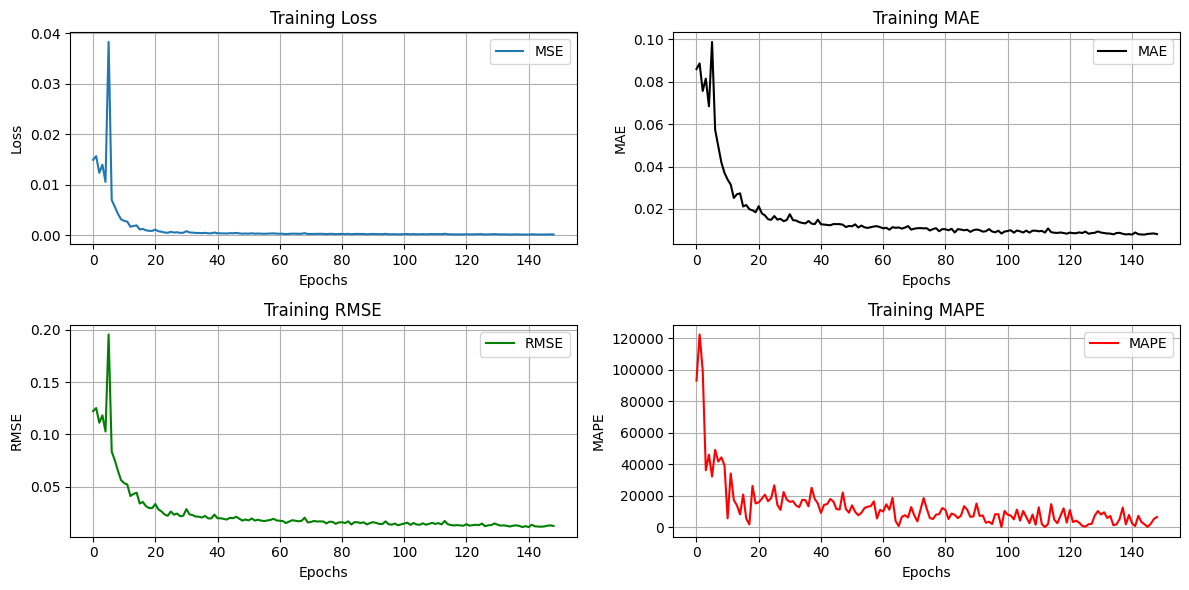

In [ ]:
####################
### Plot Results ###
####################

# Training MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['loss'][1:], label='MSE')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Training MAE
ax[0, 1].plot(history.history['mae'][1:], label='MAE', color='black')
ax[0, 1].set_title('Training MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Training RMSE
ax[1, 0].plot(history.history['root_mean_squared_error'][1:], label='RMSE', color='green')
ax[1, 0].set_title('Training RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)


# Training MAPE
ax[1, 1].plot(history.history['mape'][1:], label='MAPE', color='red')
ax[1, 1].set_title('Training MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

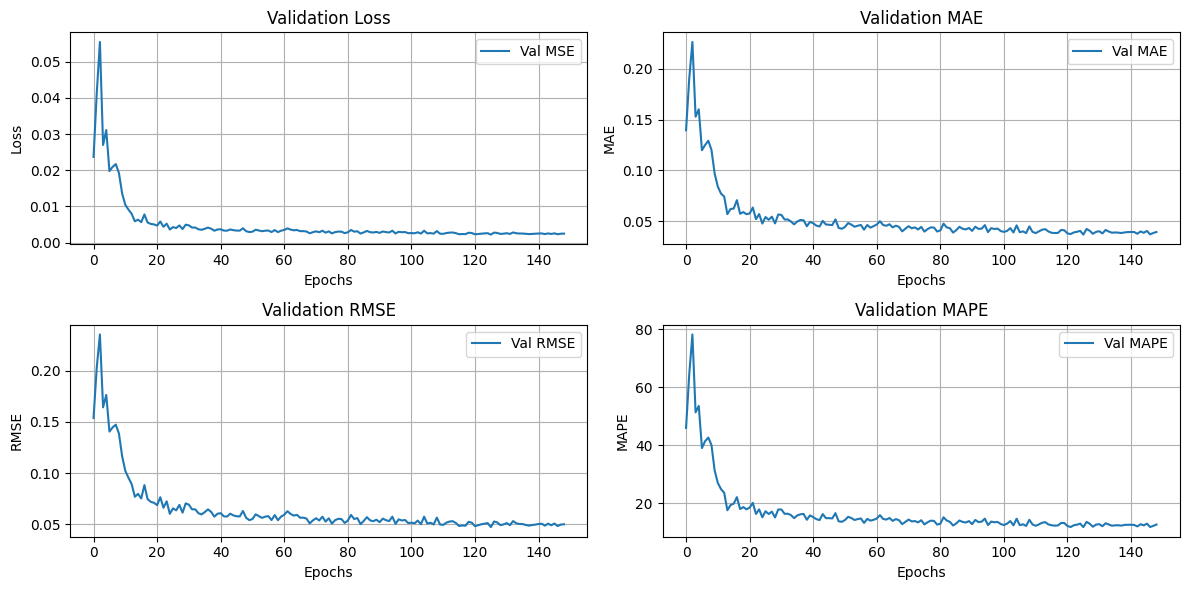

In [ ]:
# Validation MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['val_loss'][1:], label='Val MSE')
ax[0, 0].set_title('Validation Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Validation MAE
ax[0, 1].plot(history.history['val_mae'][1:], label='Val MAE')
ax[0, 1].set_title('Validation MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Validation RMSE
ax[1, 0].plot(history.history['val_root_mean_squared_error'][1:], label='Val RMSE')
ax[1, 0].set_title('Validation RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)


# Validation MAPE
ax[1, 1].plot(history.history['val_mape'][1:], label='Val MAPE')
ax[1, 1].set_title('Validation MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Store best training/validation metrics
# Training
train_mse = history.history['loss']
best_epoch = np.argmin(train_mse)
best_train_mse = train_mse[best_epoch]
best_train_rmse = history.history['root_mean_squared_error'][best_epoch]
best_train_mae  = history.history['mae'][best_epoch]
best_train_mape = history.history['mape'][best_epoch]

# Validation: record epoch at which validation loss is the lowest for each seed
val_mse = history.history['val_loss']
best_epoch = np.argmin(val_mse)
best_val_mse = val_mse[best_epoch]
best_val_rmse = history.history['val_root_mean_squared_error'][best_epoch]
best_val_mae  = history.history['val_mae'][best_epoch]
best_val_mape = history.history['val_mape'][best_epoch]

In [ ]:
#####################
## Predict/Testing ##
#####################

y_predict= model.predict([X_cnn_test, X_lstm_test])

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


In [ ]:
# -----------------------------------
# Step 10 — Test MSE/RMSE/MAE/MAPE/R2
# -----------------------------------

# Compute the loss metrics
test_mse = mean_squared_error(y_test, y_predict)
test_rmse = root_mean_squared_error(y_test, y_predict)
test_mae = mean_absolute_error(y_test, y_predict)
test_mape = mean_absolute_percentage_error(y_test, y_predict)
test_r2_score = r2_score(y_test, y_predict)

print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Mean Absolute Error:", test_mae)
print("Mean Absolute Percentage Error:", test_mape)
print("R2 Score:", test_r2_score)

Mean Squared Error: 0.00029869854252431846
Root Mean Squared Error: 0.017282897399577377
Mean Absolute Error: 0.012778165359534764
Mean Absolute Percentage Error: 0.11494080965002904
R2 Score: 0.8669561353562176


In [ ]:
#-------------------------------------------------
# Step 11 - Inverse scaling: original price scale
#-------------------------------------------------

y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)

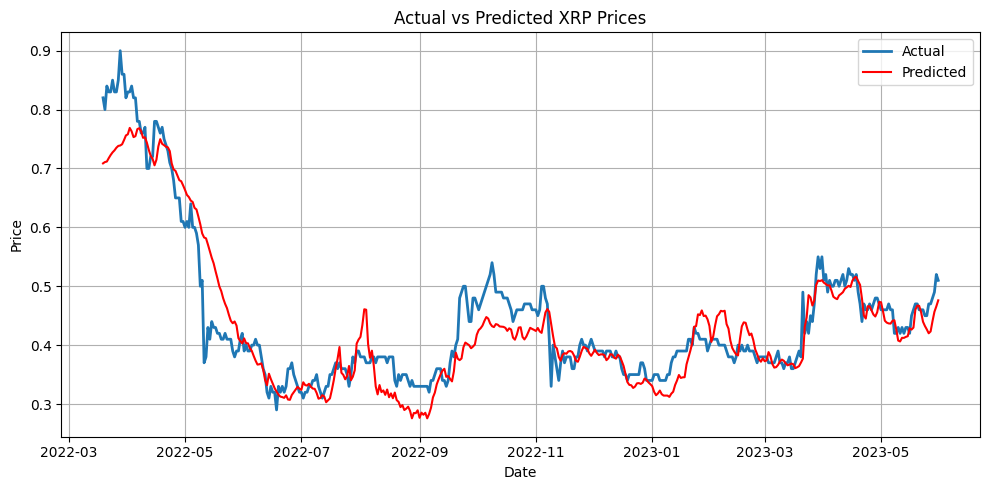

In [ ]:
#----------------------------------------------
# Step 12 - Plot prediction vs. actuals prices
#----------------------------------------------

# Add window size
start_index = len(y_train)+len(y_val)+ 224

# Test set dates + convert to datetime
dates = xrp['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted XRP Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Store metrics in dataframe along with best training/validation loss (record epoch)
results = {
    "seed": 45,
    "best_epoch": best_epoch + 1,    # best validation epoch
    "train_mse": best_train_mse,
    "train_rmse": best_train_rmse,
    "train_mae": best_train_mae,
    "train_mape": best_train_mape,
    "val_mse": best_val_mse,
    "val_rmse": best_val_rmse,
    "val_mae": best_val_mae,
    "val_mape": best_val_mape,
    "test_mse": test_mse,
    "test_rmse": test_rmse,
    "test_mae": test_mae,
    "test_mape": test_mape,
    "test_r2_score": test_r2_score
}

xrp_results = pd.DataFrame([results])
xrp_results.to_csv('xrp_results.csv')

from google.colab import files
files.download('xrp_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export results

loss_results = pd.DataFrame(history.history)
loss_results.to_csv('xrp_loss_results.csv')

from google.colab import files
files.download('xrp_loss_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Regime Classification**

In [ ]:
# ------------------------------------------
# Step 1 — Compute Log returns & Volatility
# ------------------------------------------

original = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.ravel()
})

predicted = pd.DataFrame({
    'Date': dates,
    'Predicted': y_predict_orig.ravel()
})

# Compute returns from actual and predicted prices
returns_orig = original['Actual'].pct_change()
returns_pred = predicted['Predicted'].pct_change()
# Drop NaN values from returns
returns_orig = returns_orig.fillna(0)
returns_pred = returns_pred.fillna(0)

# Compute 10-day rolling volatility
volatility_orig = returns_orig.rolling(window=10).std()
volatility_pred = returns_pred.rolling(window=10).std()
volatility_orig = volatility_orig.fillna(0)
volatility_pred = volatility_pred.fillna(0)

# Update dataframes with returns and volatility
original['Returns'] = returns_orig
predicted['Returns'] = returns_pred
original['Volatility'] = volatility_orig
predicted['Volatility'] = volatility_pred


In [ ]:
# --------------------------------
# Step 2 — Label Volatility L-M-H
# --------------------------------

# Compute quantiles as thresholds for low/med/high volatility
low_threshold = volatility_orig.quantile(0.33)   # lower 33%
high_threshold = volatility_orig.quantile(0.67)  # upper 33%

# Label volatility
def label_volatility(vol):
    if vol <= low_threshold:
        return 'low'
    elif vol >= high_threshold:
        return 'high'
    else:
        return 'medium'

# Apply volatility low/medium/high to original and prediction dataset
original['Volatility_level'] = original['Volatility'].apply(label_volatility)
predicted['Volatility_level'] = predicted['Volatility'].apply(label_volatility)

In [ ]:
# -------------------------------
# Step 3 — Regime Classification
# -------------------------------

# Classify regime based on volatility + average sign of the returns
def classify_regime(pred_labels, vol_value, vol_threshold=(low_threshold, high_threshold), window=3):
    regimes = []
    low_threshold, high_threshold = vol_threshold

    for i in range(len(pred_labels) - window):
        window_preds = pred_labels[i:i+window]
        window_vol = vol_value[i+window]
        sign_pred = np.sign(window_preds.mean())

        if window_vol <= low_threshold:
            regimes.append("Neutral")

        else:
            if sign_pred > 0:
                regimes.append("Bull")
            elif sign_pred < 0:
                regimes.append("Bear")
            else:
                regimes.append("Uncertain")

    return regimes

vol_value = original['Volatility']
regimes = classify_regime(original['Returns'], vol_value)

/tmp/ipython-input-2928619468.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


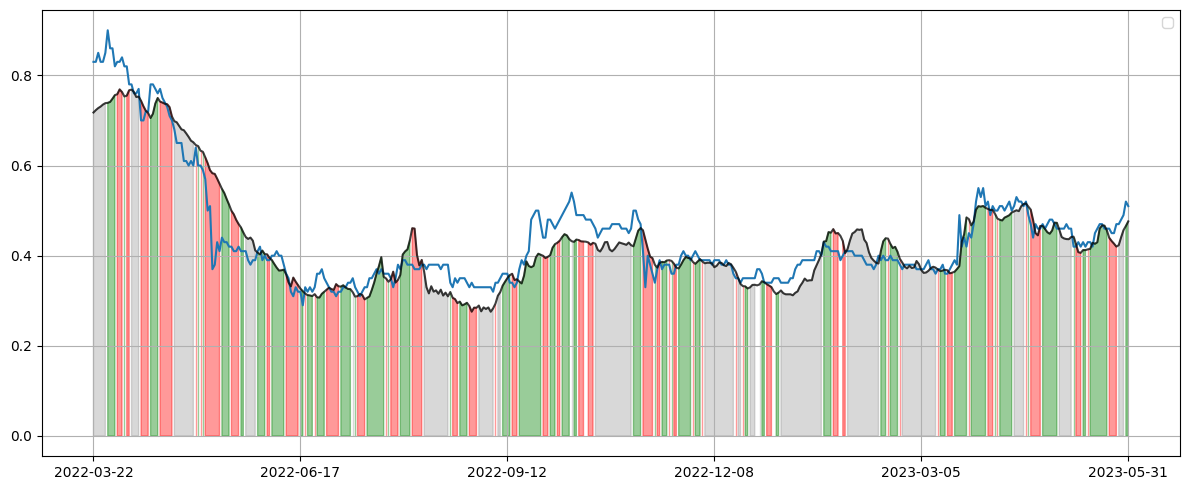

In [ ]:
####################
######  Plots ######
####################

# Plot price vs. date regime shifts in
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Actual'][3:])
plt.plot(original['Date'][3:], predicted['Predicted'][3:], color='black', alpha=0.75)

plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bull' for r in regimes], color='green', alpha=0.4);
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bear' for r in regimes], color='red', alpha=0.4);
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Neutral' for r in regimes], color='grey', alpha=0.3);

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2006677897.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


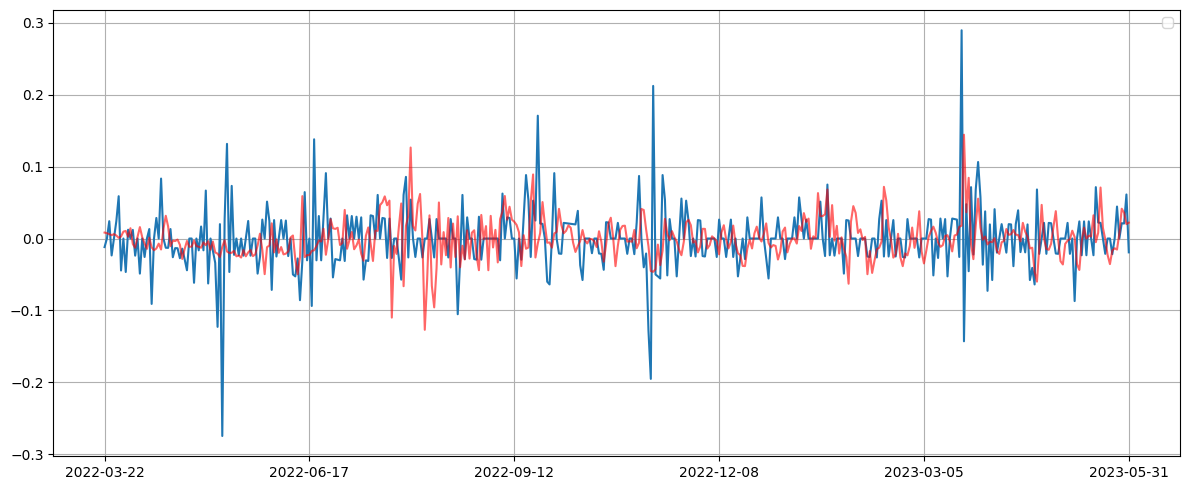

In [ ]:
# Plot regime shift for log returns vs. date
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Returns'][3:])
plt.plot(original['Date'][3:], predicted['Returns'][3:], color='red', alpha=0.6)

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

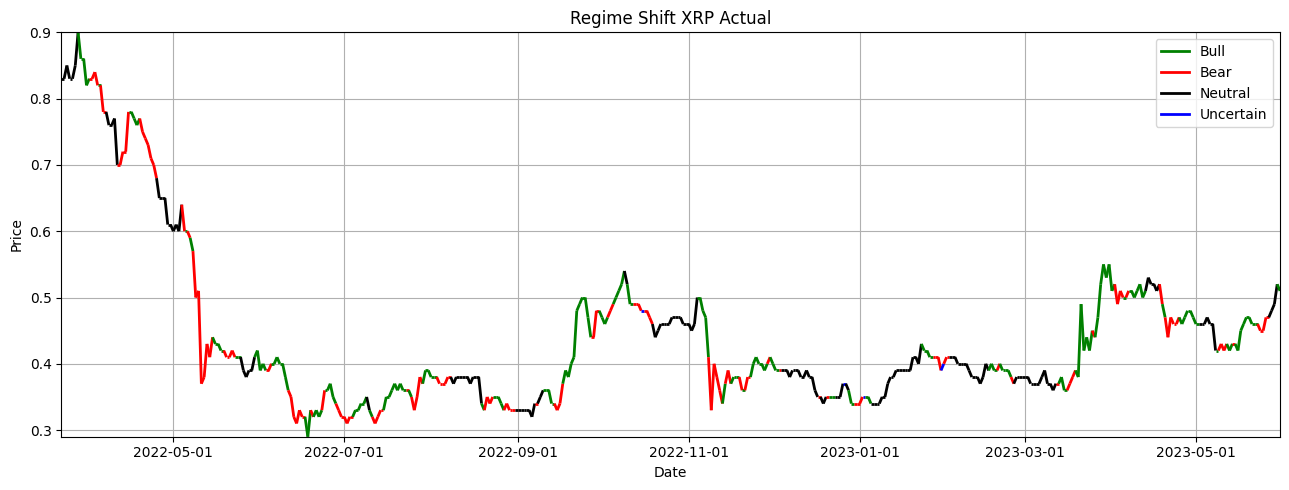

In [ ]:
# Plot price vs. date regime shift

# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = original['Actual'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(13, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift XRP Actual")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()

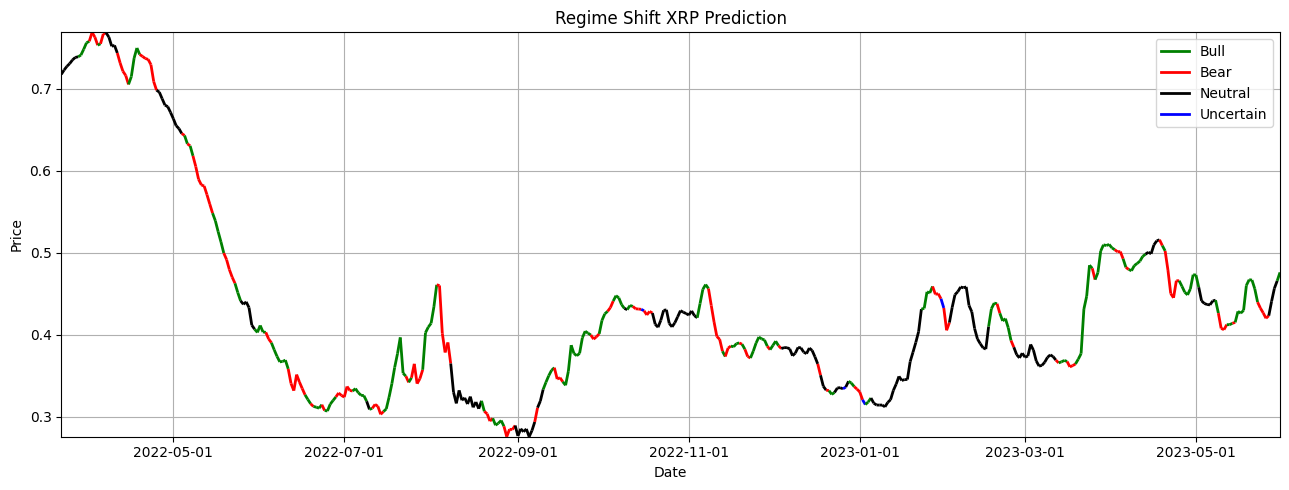

In [ ]:
# Plot price vs. date regime shift

# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = predicted['Predicted'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(13, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift XRP Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()